In [1]:
pip install meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## API Test Code

<class 'pandas.core.frame.DataFrame'>
                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2018-01-01 00:00:00   0.6  -5.6  63.0   NaN   NaN  340.0  18.4   NaN  1024.6   
2018-01-01 01:00:00  -1.1  -6.6  66.0   0.0   NaN  320.0  16.6   NaN  1025.4   
2018-01-01 02:00:00  -1.1  -9.5  53.0   0.0   NaN  330.0  22.3   NaN  1025.8   
2018-01-01 03:00:00  -1.1 -10.0  51.0   0.0   NaN  330.0  25.9   NaN  1025.6   
2018-01-01 04:00:00  -1.7 -10.5  51.0   0.0   NaN  340.0  18.4   NaN  1026.1   

                     tsun  coco  
time                             
2018-01-01 00:00:00   NaN   NaN  
2018-01-01 01:00:00   NaN   NaN  
2018-01-01 02:00:00   NaN   NaN  
2018-01-01 03:00:00   NaN   NaN  
2018-01-01 04:00:00   NaN   NaN  


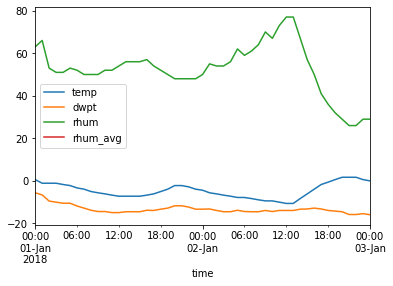

<class 'pandas.core.frame.DataFrame'>
Index(['name', 'country', 'region', 'wmo', 'icao', 'latitude', 'longitude',
       'elevation', 'timezone', 'hourly_start', 'hourly_end', 'daily_start',
       'daily_end', 'monthly_start', 'monthly_end', 'distance'],
      dtype='object')
<class 'str'>
71201
            temp_mean  dwpt_mean  rhum_mean  pres_mean  temp_min  dwpt_min  \
time                                                                         
2018-01-01   1.404167   0.354167     93.000        NaN       0.0      -0.8   
2018-01-02   1.691667   1.216667     96.625        NaN       0.0      -0.1   

            rhum_min  pres_min  temp_max  dwpt_max  rhum_max  pres_max  
time                                                                    
2018-01-01      77.0       NaN       3.9       1.9      99.0       NaN  
2018-01-02      87.0       NaN       3.8       3.3      99.0       NaN  


In [1]:
# https://dev.meteostat.net/python/

# Import standard packages
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Import Meteostat library and dependencies
from meteostat import Stations, Daily
from meteostat import Hourly

# ## Daily Data
# # Set time period
# start = datetime(2018, 1, 1)
# end = datetime(2018, 12, 31)
# # Get daily data
# data = Daily('10637', start, end)
# data = data.fetch()
# print(data)
# # Plot line chart including average, minimum and maximum temperature
# data.plot(y=['tavg', 'tmin', 'tmax'])
# plt.show()

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 1, 3)
#end = datetime(2018, 12, 31, 23, 59)

# Get hourly data
data = Hourly('72219', start, end)
data = data.fetch()

# Print DataFrame
print(type(data))
print(data.head())

# Save csv to local working directory, then have to manually download the *.csv file from the left-hand pane.
data.to_csv('test_data2.csv')

# Take moving avg of humidity data
data['rhum_avg'] = data['rhum'].rolling(60*3).mean()

# Plot data
data.plot(y=['temp','dwpt', 'rhum', 'rhum_avg'])
plt.show()

# Get station number
stations = Stations()
stations = stations.nearby(49.2497, -123.1193)
station1 = stations.fetch(1)
print(type(station1))
print(station1.columns)
station_id = station1['wmo'].iloc[0]
print(type(station_id))
print(station_id)
#print(station1)

# Get data from station number
data = Hourly(station_id, start, end)
data = data.fetch()

# Simplify data
keep_cols = ['temp','dwpt', 'rhum', 'pres']
means = data[keep_cols].groupby(pd.Grouper(freq='1D')).mean()
means = means.add_suffix('_mean')
maxs = data[keep_cols].groupby(pd.Grouper(freq='1D')).max()
maxs = maxs.add_suffix('_max')
mins = data[keep_cols].groupby(pd.Grouper(freq='1D')).min()
mins = mins.add_suffix('_min')
final = pd.concat([means, mins, maxs], axis=1)
final = final.iloc[:-1,:] # need to drop last row (last date in table is one datapoint for that date)
print(final.head())

## Functions

In [14]:
def get_station(lat, lon, start, end, verbose=False):
  stations = Stations()
  stations = stations.nearby(lat, lon)
  i = 0
  find_flag = False
  while find_flag == False:
    current_station = stations.fetch().iloc[i,:]
    delta = (current_station['hourly_end'] - end).days
    if abs(delta) < 30: find_flag = True
    i+=1
  station_id = stations.fetch().index[i-1]
  station_out = current_station
  if verbose: print('Station selected: Name={}, WMO={}, ({:0.2f}, {:0.2f})'.format(station_out['name'], station_out['wmo'], station_out['latitude'], station_out['longitude']))
  return station_id

def get_weather(lat, lon, start, end, verbose=False):
  id = get_station(lat, lon, start, end, verbose)
  data = Hourly(id, start, end)
  data = data.fetch()
  return data

def summarize_data(df_in):
  keep_cols = ['temp','dwpt', 'rhum', 'pres']
  means = df_in[keep_cols].groupby(pd.Grouper(freq='1D')).mean()
  means = means.add_suffix('_mean')
  maxs = df_in[keep_cols].groupby(pd.Grouper(freq='1D')).max()
  maxs = maxs.add_suffix('_max')
  mins = df_in[keep_cols].groupby(pd.Grouper(freq='1D')).min()
  mins = mins.add_suffix('_min')
  final = pd.concat([means, mins, maxs], axis=1)
  final = final.iloc[:-1,:] # need to drop last row (last date in table is one datapoint for that date)
  return final

## Code to Test Functions & Get Right Weather Stations

In [16]:
loc2 = {'lat': 40.78, 'lon': -73.10} #{'lat': 17.96, 'lon': -66.40}
start = datetime(2022, 4, 1)
end = datetime(2022, 8, 14)
lat = loc2['lat']
lon = loc2['lon']
stations = Stations()
stations = stations.nearby(lat, lon)
print(stations.fetch()[:10])

# print(stations.fetch().index)
# id = stations.fetch().index[1]
# print(id)
# data = Hourly(id, start, end)
# data = data.fetch()
# print(data)

print('-'*100)

# i=1
# stations = Stations()
# stations = stations.nearby(lat, lon)
# current_station = stations.fetch().iloc[i,:]
# print(current_station)
# delta = (current_station['hourly_end'] - end).days
# print(delta)

station = get_station(lat, lon, start, end, True)
print()
print(station)
data = Hourly(station, start, end)
data = data.fetch()
print(data)
# print(type(stations.fetch(1)['hourly_end'].iloc[0]))
# print((stations.fetch(1)['hourly_end'].iloc[0] - end).days)

# station = get_station(loc['lat'], loc['lon'], True)
# data = Hourly(station, start, end)
# data = data.fetch()
# print(data)
# data.plot(y=['temp','dwpt', 'rhum'])
# plt.show()

                                      name country region    wmo  icao  \
id                                                                       
72505                     Islip / Lakeland      US     NY  72505  KISP   
72503                    LaGuardia Airport      US     NY  72503  KLGA   
KHWV0                              Shirley      US     NY   <NA>  KHWV   
KFRG0       Farmingdale / East Farmingdale      US     NY   <NA>  KFRG   
KFOK0    Westhampton Beach / Suffolk Pines      US     NY   <NA>  KFOK   
72504            Sikorsky Memorial Airport      US     CT  72504  KBDR   
KHVN0              New Haven / Morris Cove      US     CT   <NA>  KHVN   
74486              John F. Kennedy Airport      US     NY  74486  KJFK   
KHPN0  White Plains / Sarosca Farm Estates      US     NY   <NA>  KHPN   
KDXR0                 Danbury / Miry Brook      US     CT   <NA>  KDXR   

       latitude  longitude  elevation          timezone hourly_start  \
id                                     

## Production

In [18]:
loc1 = {'lat': 40.78, 'lon': -73.10}
start1 = datetime(2021, 12, 1)
end1 = datetime(2022, 8, 14)
data_raw = get_weather(loc1['lat'], loc1['lon'], start1, end1, True)
data_out1 = summarize_data(data_raw)
print(data_out1)

print('\n\n\n')

loc2 = {'lat': 17.96, 'lon': -66.40}
start2 = datetime(2022, 4, 1)
end2 = datetime(2022, 8, 14)
data_raw = get_weather(loc2['lat'], loc2['lon'], start2, end2, True)
data_out2 = summarize_data(data_raw)
print(data_out2)

Station selected: Name=Islip / Lakeland, WMO=72505, (40.80, -73.10)
            temp_mean  dwpt_mean  rhum_mean    pres_mean  temp_min  dwpt_min  \
time                                                                           
2021-12-01   5.041667  -2.254167  60.958333  1018.458333       2.0      -4.6   
2021-12-02   9.750000   6.016667  77.791667  1011.375000       4.0      -1.0   
2021-12-03   7.666667  -1.675000  52.375000  1009.041667       3.0      -6.0   
2021-12-04   3.541667  -3.608333  60.125000  1019.333333       1.0      -5.9   
2021-12-05   4.666667  -3.945833  56.750000  1025.916667      -1.0      -8.6   
...               ...        ...        ...          ...       ...       ...   
2022-08-09  28.475000  23.458333  75.666667  1012.887500      24.0      22.2   
2022-08-10  26.275000  20.908333  73.333333  1015.962500      23.9      17.8   
2022-08-11  25.237500  21.295833  80.416667  1012.912500      22.4      16.8   
2022-08-12  24.779167  13.750000  55.250000  1014.01